In [1]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("dataset/track_" + no + ".csv",
                             usecols=['date', 'キロ程', '高低左'],
                             parse_dates=["date"])

In [2]:
%matplotlib inline

In [3]:
import datetime
from tqdm import tqdm
import random
import sys

In [4]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return np.array(day)

In [5]:
def feature_engineering(df, dmm, mv, admm):
    if dmm:
         df['diff_moving_mean'] = df['高低左'] - df['高低左'].rolling(window=7, min_periods=1, center=True).median()
    if mv:
        df['moving_variance'] = df['高低左'].rolling(window=7, min_periods=1, center=True).kurt()
    if admm:
        df['accumulation_diff_moving_mean'] = np.cumsum(
            abs(df['高低左'].rolling(window=3, min_periods=1, center=True).median() -
                df['高低左'].rolling(window=15, min_periods=1, center=False).median()))
    return df

In [6]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [7]:
def scaling(df, w1, w2, w3, w4):
    df['day'] = ss.fit_transform(df['day'].astype(float).values.reshape(len(df), 1))
    if w1 != 0:
        df['高低左'] = ss.fit_transform(df['高低左'].values.reshape(len(df), 1))*w1
    if w2 != 0:
        df['diff_moving_mean'] = ss.fit_transform(df['diff_moving_mean'].values.reshape(len(df), 1))*w2
    if w3 != 0:
        df['moving_variance'] = df['moving_variance'].fillna(0) #rollingした高低左が全部同じ値のときはNANになる
        df['moving_variance'] = ss.fit_transform(df['moving_variance'].values.reshape(len(df), 1))*w3
    if w4 != 0:
        df['accumulation_diff_moving_mean'] = \
        ss.fit_transform(df['accumulation_diff_moving_mean'].values.reshape(len(df), 1))*w4
    return df

In [8]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [9]:
def kd_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99999, False, True)].index.values
    return normal_id

In [10]:
def kd_outliers1(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.999, False, True)].index.values
    return normal_id

In [11]:
def kd_outliers2(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99998, False, True)].index.values
    return normal_id

In [12]:
from scipy.cluster.hierarchy import linkage, fcluster

In [13]:
def dendrogram_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, False, True)
    df = scaling(df, 10, 50, 0, 100)

    linkage_result = linkage(df, method='ward', metric='euclidean')
    threshold = 0.95 * np.max(linkage_result[:, 2])
    clustered = fcluster(linkage_result, threshold, criterion='distance')

    df['label'] = clustered
    normal_label = df['label'].mode()[0]
    normal_id = df[df['label'] == normal_label].index.values
    return normal_id

In [14]:
def remove_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])
    return local_global[3][1]

def flag_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])

    out1 = set(local_global[0][1]) - set(local_global[1][1])
    out2 = set(local_global[1][1]) - set(local_global[2][1])
    out3 = set(local_global[2][1]) - set(local_global[3][1])
    normal = local_global[3][1]
    return out1, out2, out3, normal

fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['C']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [18]:
def get_slope_variance(X, y):
    if len(X) < 10:
        slope = 100
        variance = 100
    else:
        data = np.array([X, y]).T
        pca.fit(data)
        cmp = pca.components_
        cov = pca.get_covariance()

        slope = cmp[0, 1] / cmp[0, 0]
        variance = cov[1, 1] / cov[0, 0]

    return slope, variance

In [19]:
def get_intercept(raw):
    data = raw.copy()
    if sum(data['date'] >= "2018-03-01") == 0:
        print('sum(data["date"] >= "2018-03-01") == 0')
        intercept = np.median(data['高低左'].values[-10:])

    else:
        data = data.loc[data['date'] >= "2018-03-01"]
        data = data.reset_index(drop=True)
        data = data.drop('date', axis=1)
        if len(data) < 4:
            print('sum(data["date"] >= "2018-03-01") < 4')
            intercept = np.median(data['高低左'].values)

        else:
            normal_id = kd_outliers1(data)
            data = data.loc[normal_id]
            intercept = np.median(data['高低左'].values)

    return intercept

In [20]:
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [26]:
%%time
random.seed(0)

summarys = {}
for no in tqdm(['A', 'B', 'C', 'D']):
    track = tracks[no]
    kilos = track['キロ程'].unique()
#    kilos = track['キロ程'].unique()[:10]
#    kilos = track['キロ程'].unique()[-10:]
    summary = pd.DataFrame(columns=['路線', 'キロ程', '傾き', '切片', '分散比', '測定回数', 'データ数'])

    for i, kilo in enumerate(tqdm(kilos)):
        data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
        data = data.dropna()
        data = data.reset_index(drop=True)

        n_raw_data = len(data)
        data['day'] = get_day(data['date'])
        intercept = get_intercept(data)
        data = data.drop('date', axis=1)

        if len(data) < 10:
            print("len(data) < 10")
            n_data = 0
            slope = 100
            variance = 100
        else:
            normal_id = remove_outliers(data)
            data = data.loc[normal_id]
            data = data.reset_index(drop=True)
            n_data = len(data)
            slope, variance = get_slope_variance(data['day'].values, data['高低左'].values)

        summary.loc[i, '路線'] = no
        summary.loc[i, 'キロ程'] = kilo
        summary.loc[i, '傾き'] = slope
        summary.loc[i, '切片'] = intercept
        summary.loc[i, '分散比'] = variance
        summary.loc[i, '測定回数'] = n_raw_data
        summary.loc[i, 'データ数'] = n_data

        summary['路線'] = summary['路線'].astype('category')
        summary[['傾き', '切片', '分散比']] = summary[['傾き', '切片', '分散比']].astype('float64')
        summary[['キロ程', '測定回数', 'データ数']] = summary[['キロ程', '測定回数', 'データ数']].astype('int32')

    summary.to_csv(f'summary12_refine_{no}.csv')



  0%|          | 0/4 [00:00<?, ?it/s]


0it [00:00, ?it/s]


1it [00:00,  6.86it/s]


2it [00:00,  6.09it/s]


3it [00:00,  4.03it/s]


4it [00:00,  4.30it/s]


5it [00:01,  4.96it/s]


6it [00:01,  5.43it/s]


7it [00:01,  5.32it/s]


8it [00:01,  5.24it/s]


9it [00:01,  5.99it/s]


10it [00:01,  5.53it/s]


11it [00:02,  4.04it/s]


12it [00:02,  3.22it/s]


13it [00:03,  2.71it/s]


14it [00:03,  2.85it/s]


15it [00:03,  3.56it/s]


16it [00:04,  3.45it/s]


17it [00:04,  3.11it/s]


18it [00:04,  2.71it/s]


19it [00:05,  2.66it/s]


20it [00:05,  2.75it/s]


21it [00:05,  3.43it/s]


22it [00:06,  3.14it/s]


23it [00:06,  3.07it/s]


24it [00:07,  2.55it/s]


25it [00:07,  2.38it/s]


26it [00:07,  2.76it/s]


27it [00:08,  2.68it/s]


28it [00:08,  2.64it/s]


29it [00:09,  2.35it/s]


30it [00:09,  2.57it/s]


31it [00:09,  2.95it/s]


32it [00:09,  3.61it/s]


33it [00:09,  4.07it/s]


34it [00:10,  4.07it/s]


35it [00:10,  3.63it/s]


36it [00:11,  2.78it/s]


37it [00:1

KeyboardInterrupt: 

In [24]:
summary#.info()

,路線,キロ程,傾き,切片,分散比,測定回数,データ数
0,D,25681,0.007854,7.490,0.000258,184,60
1,D,25682,0.005319,6.285,0.000283,201,52
2,D,25683,0.005233,3.330,0.000162,200,43
3,D,25684,0.001904,-1.305,0.000360,184,47
4,D,25685,-0.025063,-6.580,0.001409,182,37
5,D,25686,-0.000594,-10.660,0.000176,182,67
6,D,25687,0.009102,-9.470,0.000160,181,38
7,D,25688,0.007423,-5.370,0.000290,170,43
8,D,25689,-0.000547,-0.105,0.000144,166,47
9,D,25690,-0.002646,3.655,0.000458,153,30


# LightGBM

In [72]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = pd.read_csv(f'summary12_refine_{no}.csv', index_col=0)

In [73]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].loc[summarys[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['分散比'] == 100, '分散比'] = \
    np.median(summarys[no].loc[summarys[no]['分散比'].notnull(), '分散比'])
    summarys[no].loc[summarys[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['切片'].isnull(), '切片'] = \
    np.median(summarys[no].loc[summarys[no]['切片'].notnull(), '切片'])

In [50]:
summarys["B"]

,路線,キロ程,傾き,切片,分散比,測定回数,データ数
0,B,10000,-0.004394,-4.845,0.000059,233,64
1,B,10001,-0.004061,-5.200,0.000037,238,57
2,B,10002,-0.001270,-2.895,0.000016,238,79
3,B,10003,0.005208,0.760,0.000036,238,79
4,B,10004,0.011723,3.410,0.000171,237,86
5,B,10005,0.013871,3.300,0.000242,237,80
6,B,10006,0.010191,0.510,0.000124,238,74
7,B,10007,0.002232,-3.210,0.000017,237,72
8,B,10008,-0.005757,-5.760,0.000073,239,78
9,B,10009,-0.010900,-5.960,0.000206,238,74


In [51]:
pdp.ProfileReport(summarys["B"])

Number of variables,7
Number of observations,21531
Total Missing (%),0.0%
Total size in memory,1.3 MiB
Average record size in memory,64.0 B
Numeric,6
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,1


In [52]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [53]:
train = summarys['A']['傾き'].values
train = pd.DataFrame({'slope': train})
for i in range(30):
    train[f'lag{i+1}'] = train['slope'].shift(i+1)

In [54]:
train

,slope,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30
0,-0.003068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.002222,-0.003068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.003626,-0.002222,-0.003068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000199,-0.003626,-0.002222,-0.003068,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.002985,0.000199,-0.003626,-0.002222,-0.003068,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.000586,0.002985,0.000199,-0.003626,-0.002222,-0.003068,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-0.000215,0.000586,0.002985,0.000199,-0.003626,-0.002222,-0.003068,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.003765,-0.000215,0.000586,0.002985,0.000199,-0.003626,-0.002222,-0.003068,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.001148,0.003765,-0.000215,0.000586,0.002985,0.000199,-0.003626,-0.002222,-0.003068,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-0.001019,0.001148,0.003765,-0.000215,0.000586,0.002985,0.000199,-0.003626,-0.002222,-0.003068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
%matplotlib inline

In [58]:
X_train = train.drop(['slope'], axis=1).values
y_train = train['slope'].values
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 2000x800 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


0.07696327511182662

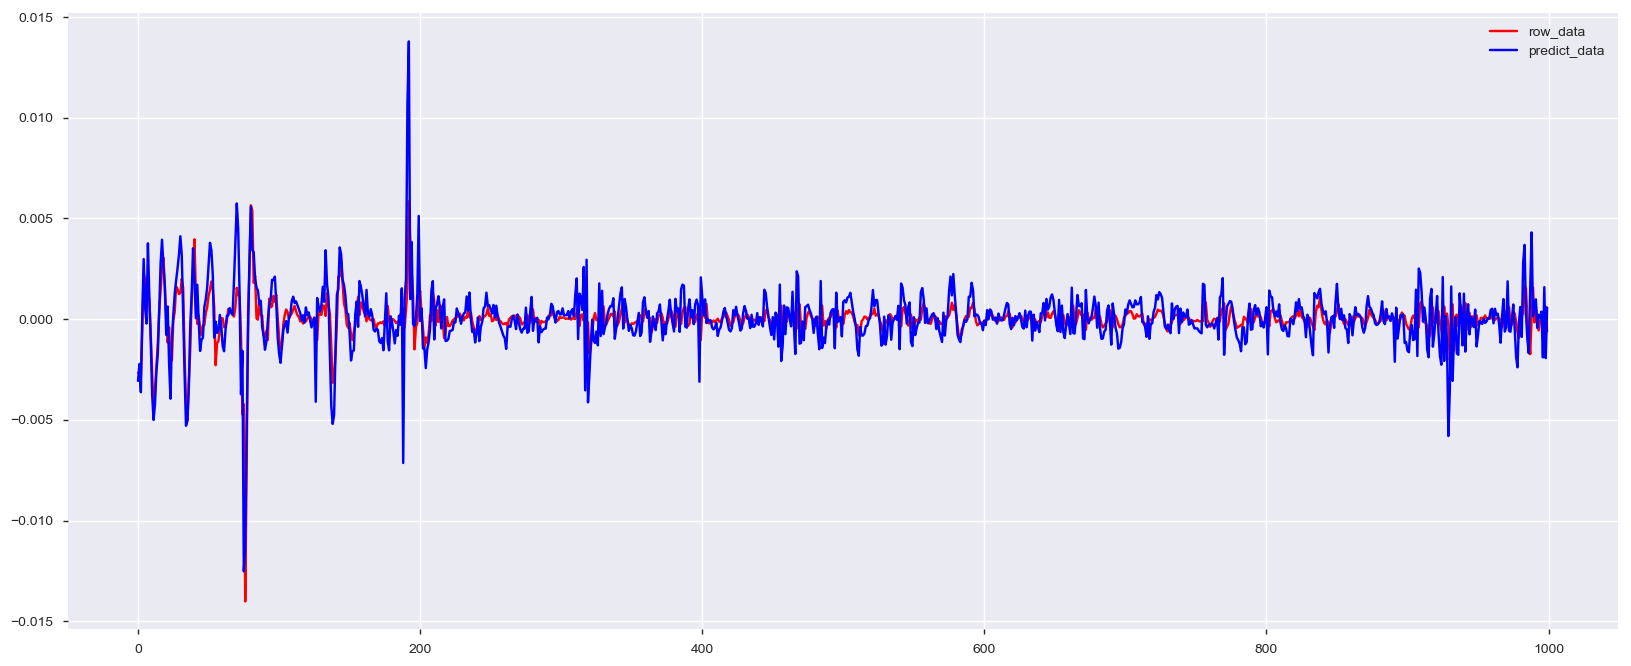

In [56]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[:1000])), train_pred[:1000], color="r", label="row_data")
plt.plot(range(len(y_train[:1000])), y_train[:1000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

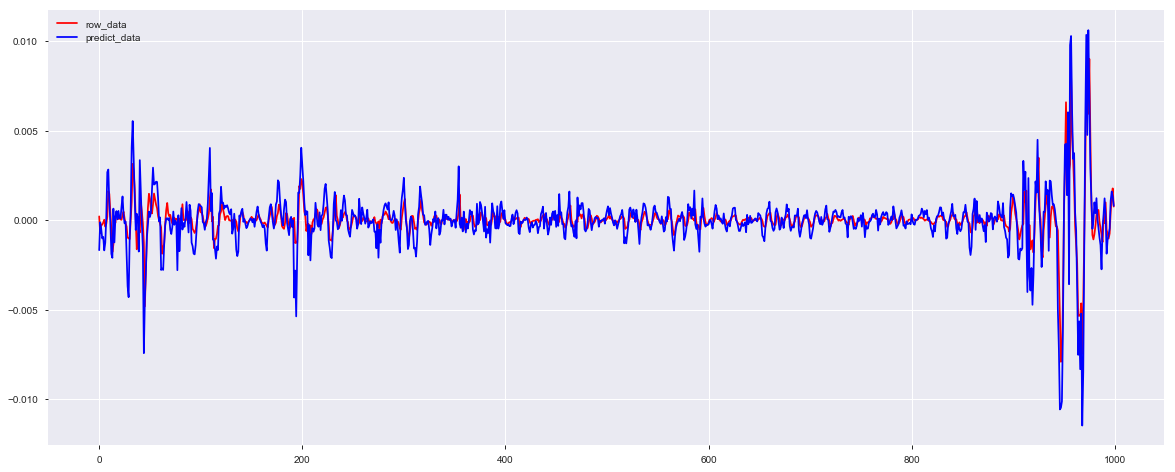

0.07696327511182662

In [59]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[-1000:])), train_pred[-1000:], color="r", label="row_data")
plt.plot(range(len(y_train[-1000:])), y_train[-1000:], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

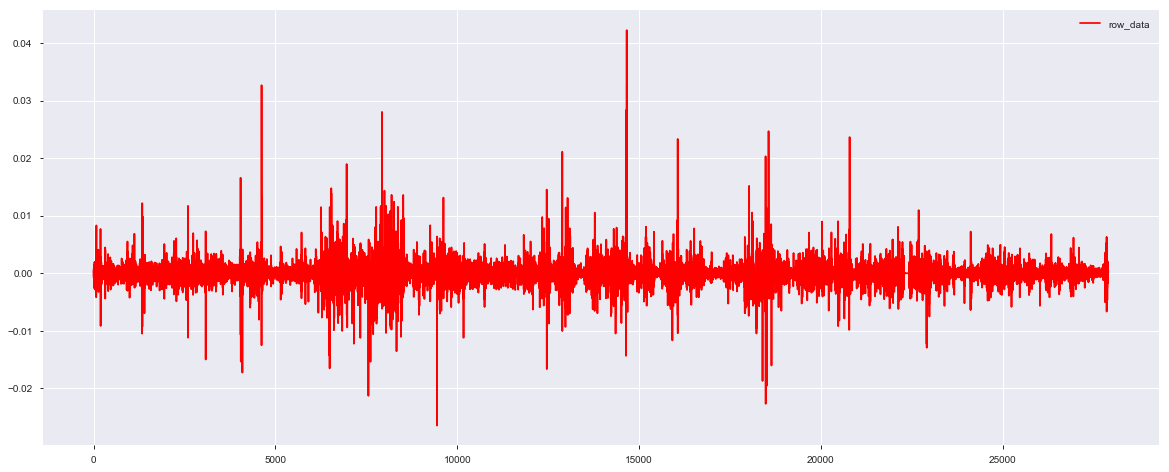

In [60]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred-y_train, color="r", label="row_data")
plt.legend()
plt.show()

In [61]:
summarys['D']

,路線,キロ程,傾き,切片,分散比,測定回数,データ数
0,D,10000,-0.001744,-0.670,0.000006,211,54
1,D,10001,0.003181,-0.450,0.000019,211,44
2,D,10002,0.002455,0.340,0.000014,212,47
3,D,10003,0.001804,1.275,0.000016,213,36
4,D,10004,0.003191,1.510,0.000047,212,40
5,D,10005,-0.000062,0.730,0.000048,213,42
6,D,10006,-0.001089,-0.400,0.000057,213,34
7,D,10007,0.002328,-1.035,0.000024,213,41
8,D,10008,0.000415,-0.315,0.000044,214,43
9,D,10009,-0.001870,1.695,0.000030,213,70


In [62]:
train = summarys['D']['傾き'].values
train = pd.DataFrame({'slope': train})
for i in range(30):
    train[f'lag{i+1}'] = train['slope'].shift(i+1)

In [63]:
train

,slope,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30
0,-0.001744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.003181,-0.001744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.002455,0.003181,-0.001744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.001804,0.002455,0.003181,-0.001744,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.003191,0.001804,0.002455,0.003181,-0.001744,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-0.000062,0.003191,0.001804,0.002455,0.003181,-0.001744,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-0.001089,-0.000062,0.003191,0.001804,0.002455,0.003181,-0.001744,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.002328,-0.001089,-0.000062,0.003191,0.001804,0.002455,0.003181,-0.001744,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.000415,0.002328,-0.001089,-0.000062,0.003191,0.001804,0.002455,0.003181,-0.001744,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-0.001870,0.000415,0.002328,-0.001089,-0.000062,0.003191,0.001804,0.002455,0.003181,-0.001744,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
X_train = train.drop(['slope'], axis=1).values
y_train = train['slope'].values
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 1440x576 with 0 Axes>

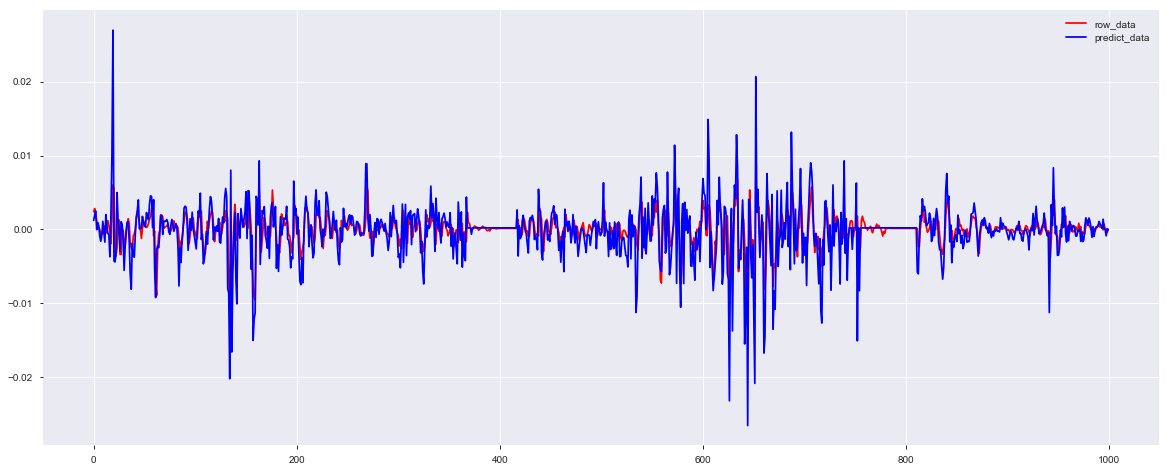

0.16541781384242685

In [65]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[3000:4000])), train_pred[3000:4000], color="r", label="row_data")
plt.plot(range(len(y_train[3000:4000])), y_train[3000:4000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

In [70]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys[no]['傾き'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [76]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].to_csv(f'summary12_refine_{no}_lgbm.csv')

summarys["A"]

%%time
submit = pd.DataFrame()
for no in ['A', 'B', 'C', 'D']:
    summary = summarys[no]
    submit = pd.concat([submit, summary[['路線', 'キロ程', '傾き', '切片']]], axis=0)
submit = submit.reset_index(drop=True)

pdp.ProfileReport(submit)

In [80]:
p = []
intercept_day = 15
for no in ['A', 'B', 'C', 'D']:
    summary = summarys[no]
    for i in range(91):
        day = summary['切片'].values + summary['傾き'].values*(i+intercept_day)
        p.extend(day)

submision = pd.DataFrame(p)
print(sum(submision.isnull()))
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし

0


In [81]:
submision.max()

0    18.45
dtype: float64

In [82]:
submision.min()

0   -18.13
dtype: float64

submision.loc[submision[0] > 16, 0] = 16
submision.loc[submision[0] < -16, 0] = -16

In [83]:
len(submision[submision[0] >= 16])
len(submision[submision[0] <= -16])

373

676

In [84]:
submision

,0
0,0.33
1,2.64
2,4.96
3,5.95
4,5.03
5,1.67
6,-3.16
7,-7.12
8,-8.84
9,-7.42


Text(0.5, 1.0, 'kilo: 28723,  kilo_id: 18723')

Text(0.5, 1.0, 'kilo: 11067,  kilo_id: 1067')

Text(0.5, 1.0, 'kilo: 24053,  kilo_id: 14053')

Text(0.5, 1.0, 'kilo: 25812,  kilo_id: 15812')

Text(0.5, 1.0, 'kilo: 28942,  kilo_id: 18942')

Text(0.5, 1.0, 'kilo: 10486,  kilo_id: 486')

Text(0.5, 1.0, 'kilo: 16753,  kilo_id: 6753')

Text(0.5, 1.0, 'kilo: 25157,  kilo_id: 15157')

Text(0.5, 1.0, 'kilo: 36650,  kilo_id: 26650')

Text(0.5, 1.0, 'kilo: 26098,  kilo_id: 16098')

Text(0.5, 1.0, 'kilo: 36987,  kilo_id: 26987')

Text(0.5, 1.0, 'kilo: 19093,  kilo_id: 9093')

Text(0.5, 1.0, 'kilo: 31412,  kilo_id: 21412')

Text(0.5, 1.0, 'kilo: 36562,  kilo_id: 26562')

Text(0.5, 1.0, 'kilo: 15250,  kilo_id: 5250')

Text(0.5, 1.0, 'kilo: 11127,  kilo_id: 1127')

Text(0.5, 1.0, 'kilo: 27061,  kilo_id: 17061')

Text(0.5, 1.0, 'kilo: 26059,  kilo_id: 16059')

Text(0.5, 1.0, 'kilo: 20740,  kilo_id: 10740')

Text(0.5, 1.0, 'kilo: 12493,  kilo_id: 2493')

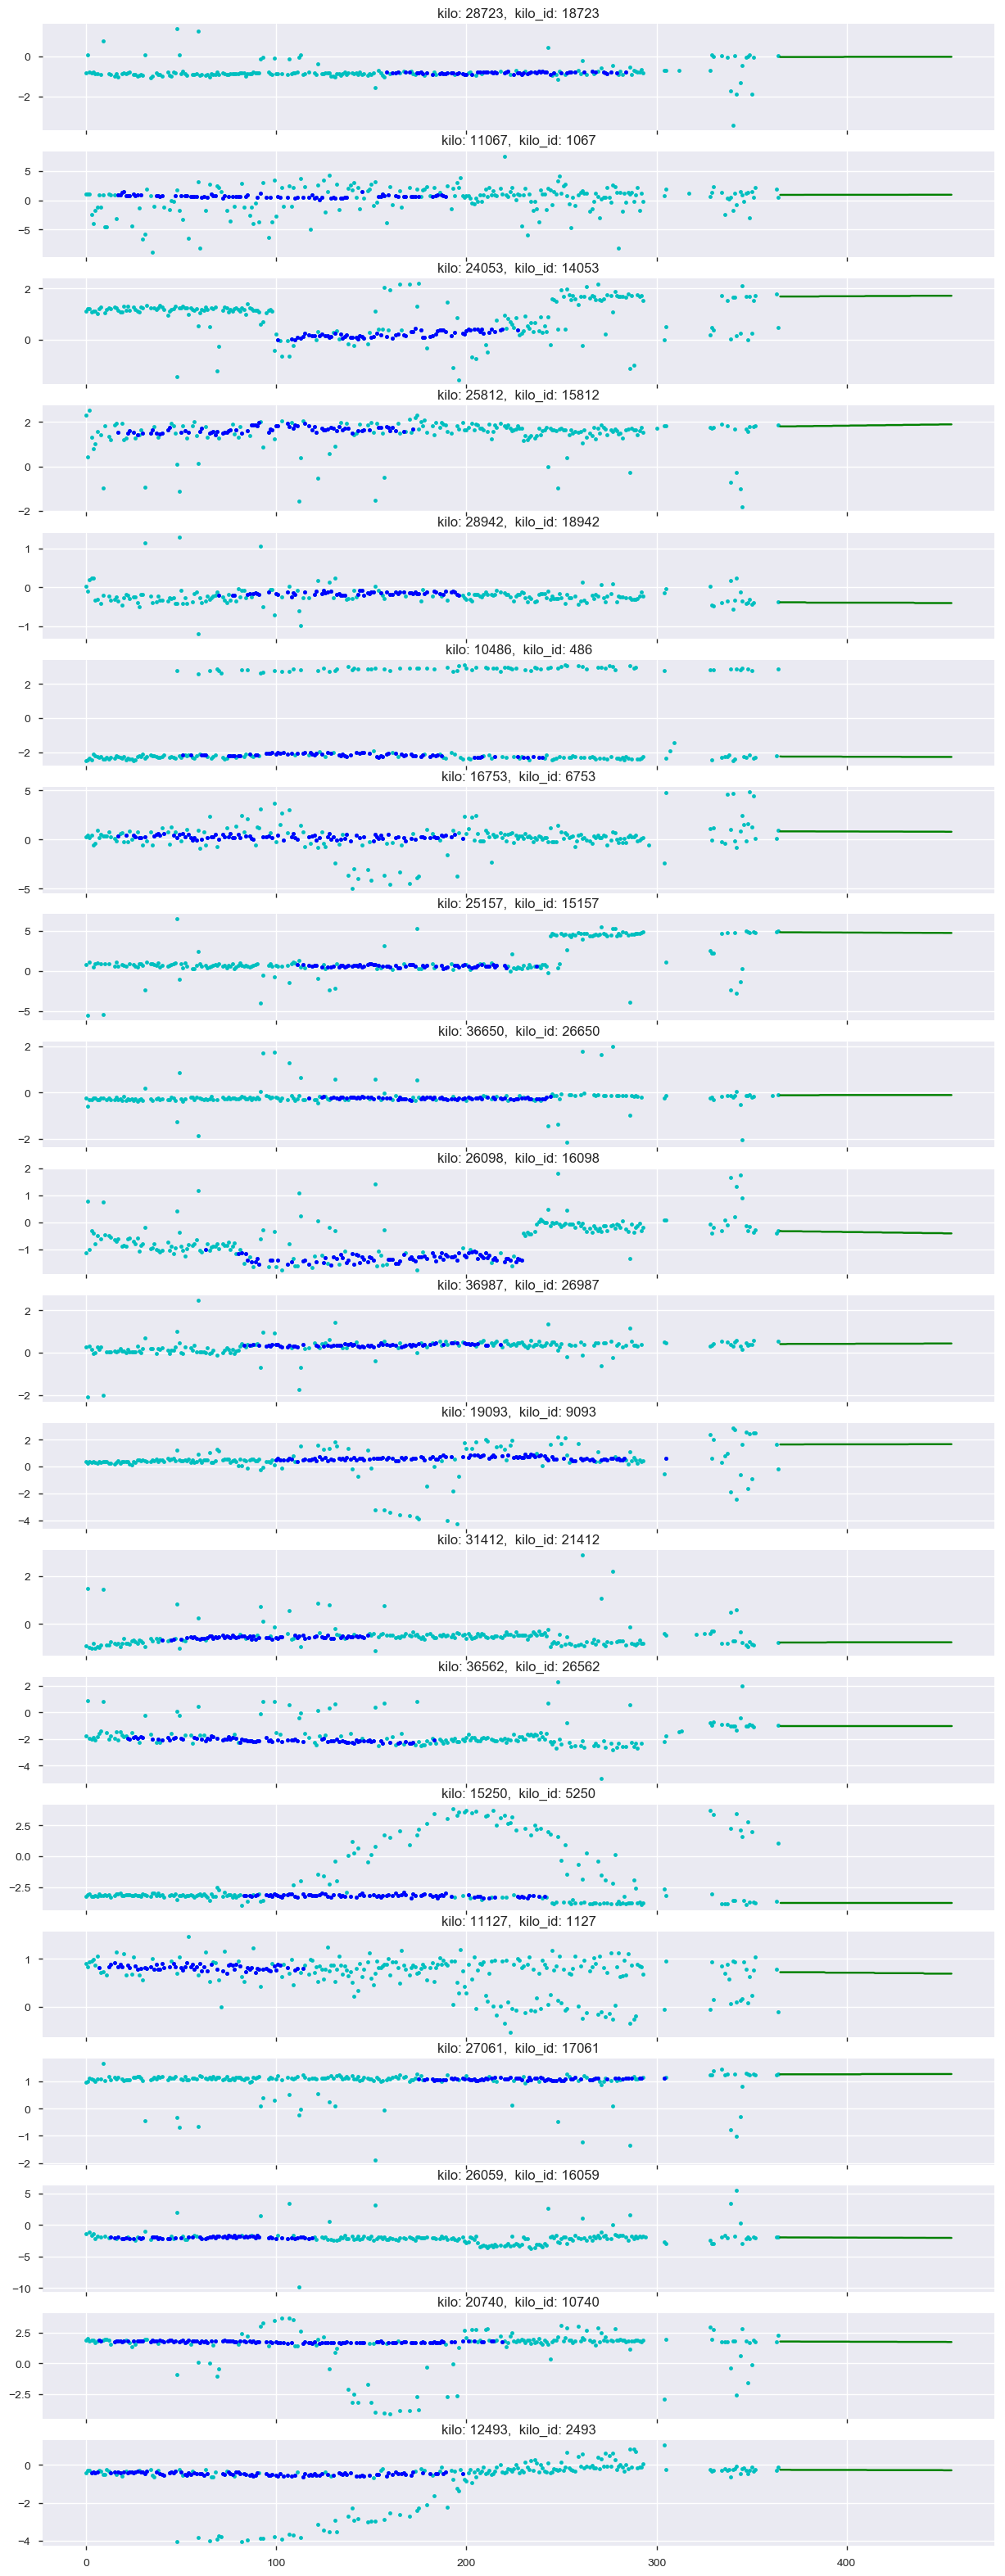

In [85]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 22623,  kilo_id: 12623')

Text(0.5, 1.0, 'kilo: 23781,  kilo_id: 13781')

Text(0.5, 1.0, 'kilo: 11326,  kilo_id: 1326')

Text(0.5, 1.0, 'kilo: 18484,  kilo_id: 8484')

Text(0.5, 1.0, 'kilo: 26753,  kilo_id: 16753')

Text(0.5, 1.0, 'kilo: 25922,  kilo_id: 15922')

Text(0.5, 1.0, 'kilo: 23268,  kilo_id: 13268')

Text(0.5, 1.0, 'kilo: 19938,  kilo_id: 9938')

Text(0.5, 1.0, 'kilo: 25617,  kilo_id: 15617')

Text(0.5, 1.0, 'kilo: 21732,  kilo_id: 11732')

Text(0.5, 1.0, 'kilo: 29116,  kilo_id: 19116')

Text(0.5, 1.0, 'kilo: 17157,  kilo_id: 7157')

Text(0.5, 1.0, 'kilo: 26537,  kilo_id: 16537')

Text(0.5, 1.0, 'kilo: 14563,  kilo_id: 4563')

Text(0.5, 1.0, 'kilo: 19235,  kilo_id: 9235')

Text(0.5, 1.0, 'kilo: 14579,  kilo_id: 4579')

Text(0.5, 1.0, 'kilo: 13107,  kilo_id: 3107')

Text(0.5, 1.0, 'kilo: 30262,  kilo_id: 20262')

Text(0.5, 1.0, 'kilo: 18208,  kilo_id: 8208')

Text(0.5, 1.0, 'kilo: 27451,  kilo_id: 17451')

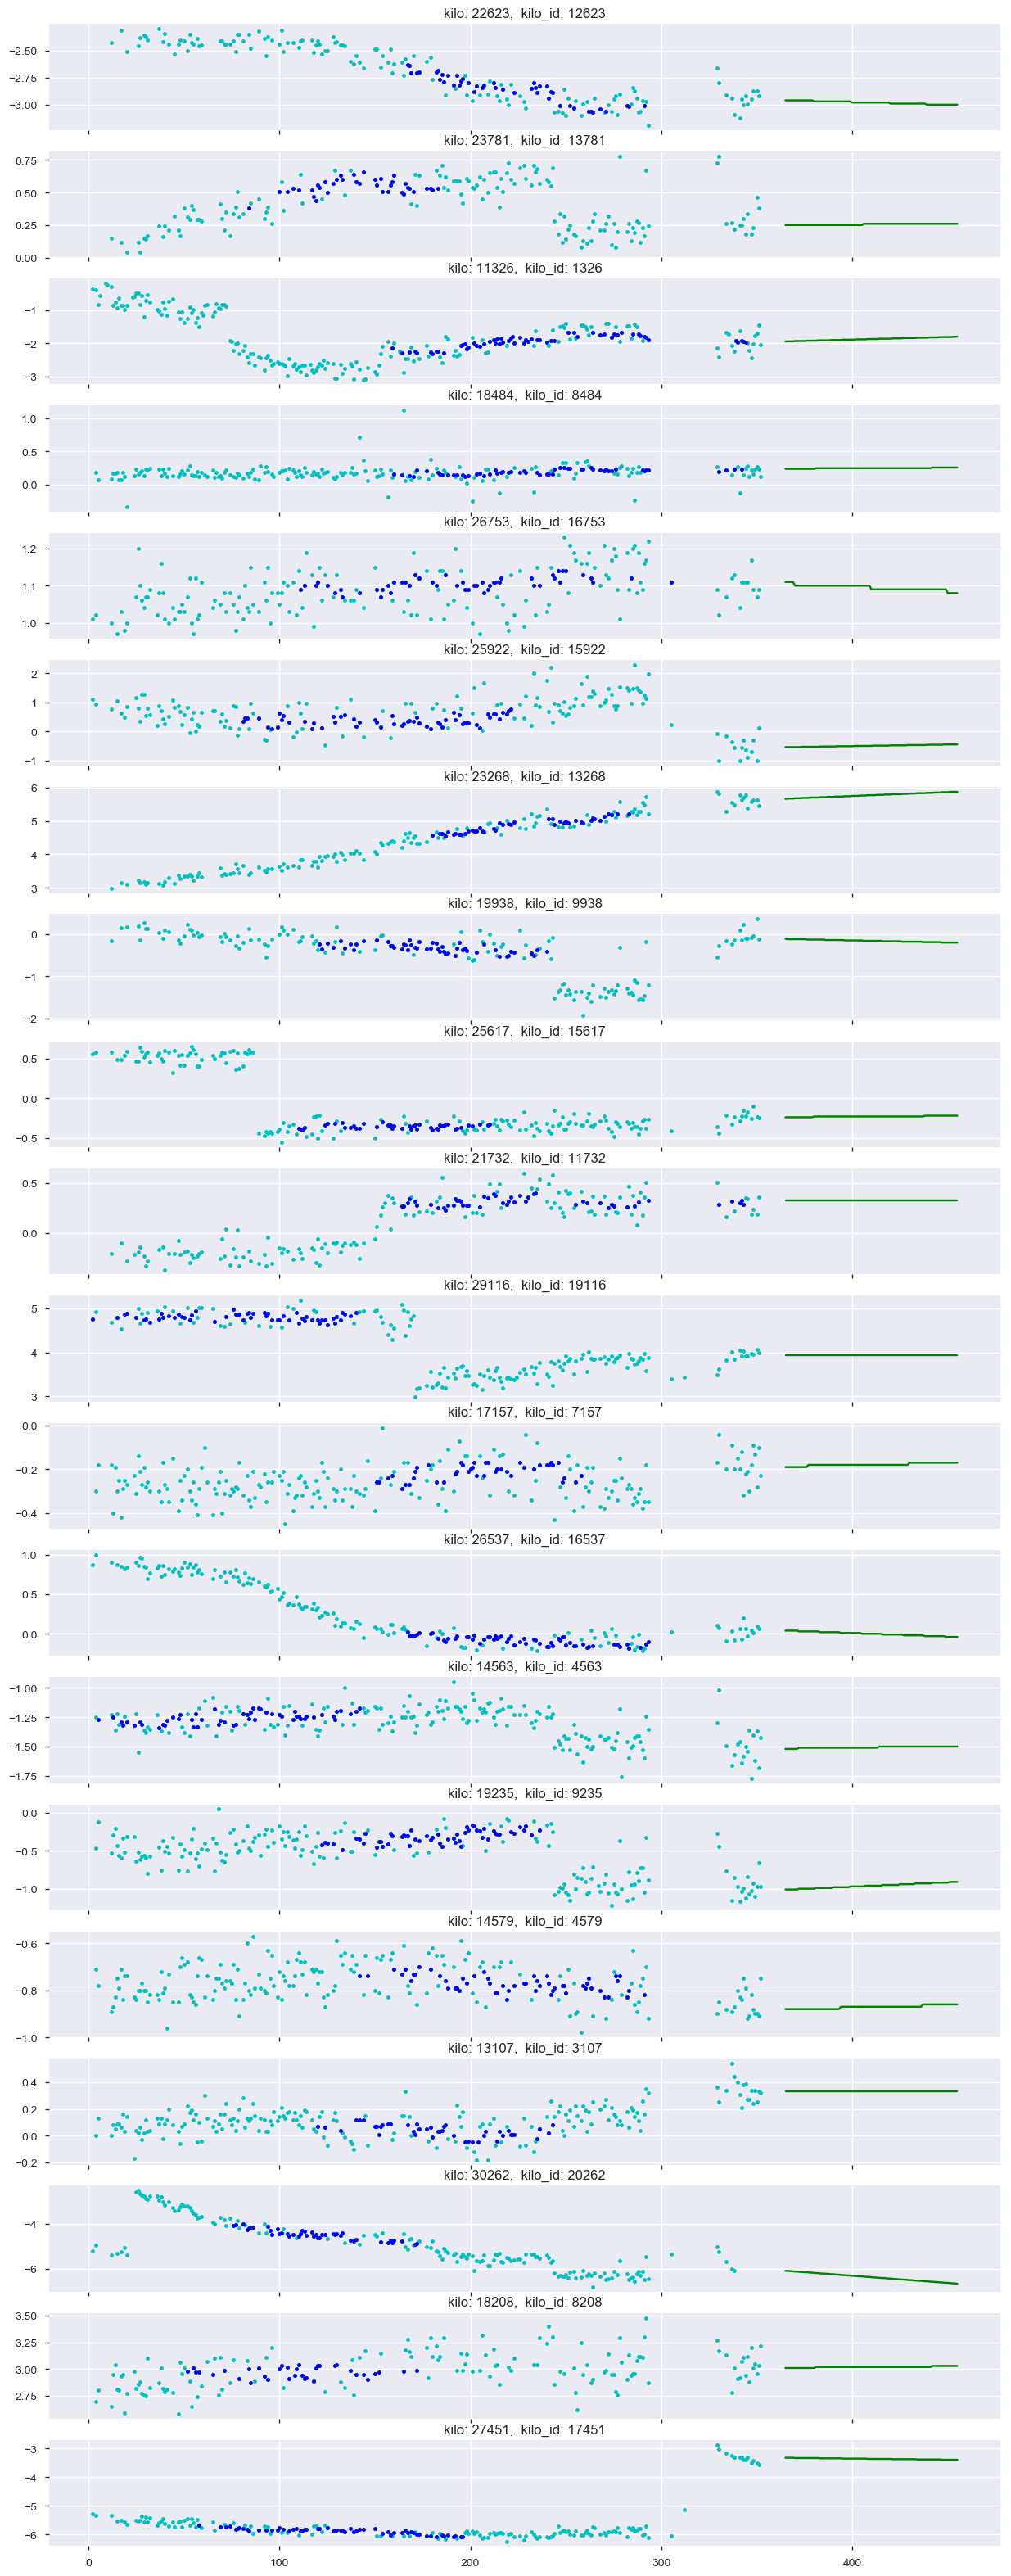

In [86]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['B']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 65340,  kilo_id: 55340')

Text(0.5, 1.0, 'kilo: 35247,  kilo_id: 25247')

Text(0.5, 1.0, 'kilo: 59673,  kilo_id: 49673')

Text(0.5, 1.0, 'kilo: 37562,  kilo_id: 27562')

Text(0.5, 1.0, 'kilo: 12653,  kilo_id: 2653')

Text(0.5, 1.0, 'kilo: 26968,  kilo_id: 16968')

Text(0.5, 1.0, 'kilo: 43506,  kilo_id: 33506')

Text(0.5, 1.0, 'kilo: 41845,  kilo_id: 31845')

Text(0.5, 1.0, 'kilo: 36537,  kilo_id: 26537')

Text(0.5, 1.0, 'kilo: 61367,  kilo_id: 51367')

Text(0.5, 1.0, 'kilo: 64385,  kilo_id: 54385')

Text(0.5, 1.0, 'kilo: 29877,  kilo_id: 19877')

Text(0.5, 1.0, 'kilo: 41234,  kilo_id: 31234')

Text(0.5, 1.0, 'kilo: 33465,  kilo_id: 23465')

Text(0.5, 1.0, 'kilo: 48232,  kilo_id: 38232')

Text(0.5, 1.0, 'kilo: 24315,  kilo_id: 14315')

Text(0.5, 1.0, 'kilo: 43075,  kilo_id: 33075')

Text(0.5, 1.0, 'kilo: 19127,  kilo_id: 9127')

Text(0.5, 1.0, 'kilo: 28470,  kilo_id: 18470')

Text(0.5, 1.0, 'kilo: 19158,  kilo_id: 9158')

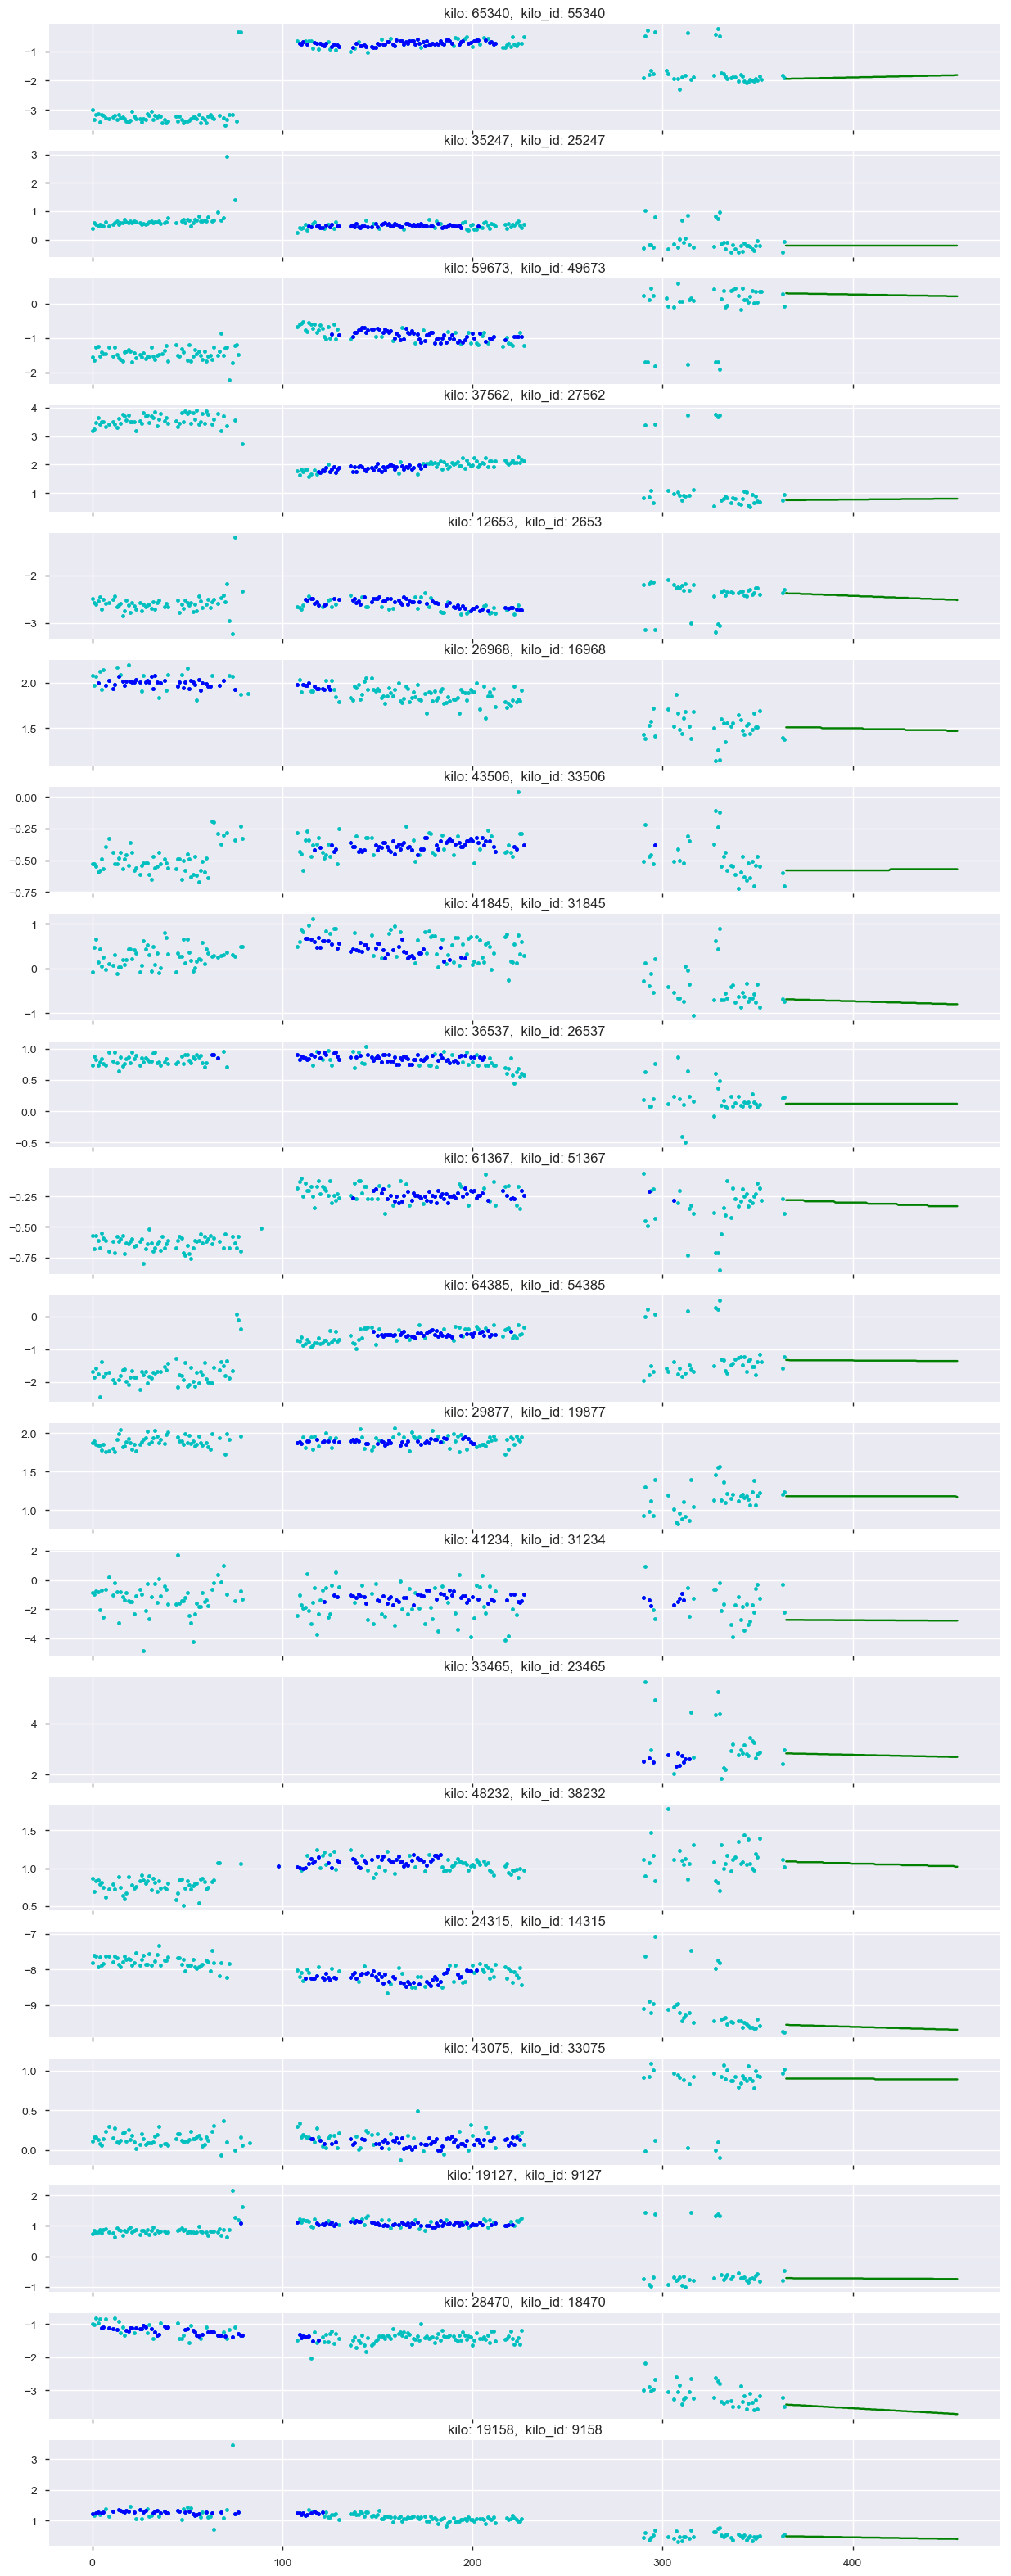

In [87]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['C']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 23835,  kilo_id: 13835')

Text(0.5, 1.0, 'kilo: 16311,  kilo_id: 6311')

Text(0.5, 1.0, 'kilo: 22418,  kilo_id: 12418')

Text(0.5, 1.0, 'kilo: 24585,  kilo_id: 14585')

Text(0.5, 1.0, 'kilo: 16890,  kilo_id: 6890')

Text(0.5, 1.0, 'kilo: 10663,  kilo_id: 663')

Text(0.5, 1.0, 'kilo: 14242,  kilo_id: 4242')

Text(0.5, 1.0, 'kilo: 18376,  kilo_id: 8376')

Text(0.5, 1.0, 'kilo: 17961,  kilo_id: 7961')

Text(0.5, 1.0, 'kilo: 16634,  kilo_id: 6634')

Text(0.5, 1.0, 'kilo: 25044,  kilo_id: 15044')

Text(0.5, 1.0, 'kilo: 22841,  kilo_id: 12841')

Text(0.5, 1.0, 'kilo: 23596,  kilo_id: 13596')

Text(0.5, 1.0, 'kilo: 14969,  kilo_id: 4969')

Text(0.5, 1.0, 'kilo: 17808,  kilo_id: 7808')

Text(0.5, 1.0, 'kilo: 15866,  kilo_id: 5866')

Text(0.5, 1.0, 'kilo: 19558,  kilo_id: 9558')

Text(0.5, 1.0, 'kilo: 24608,  kilo_id: 14608')

Text(0.5, 1.0, 'kilo: 24878,  kilo_id: 14878')

Text(0.5, 1.0, 'kilo: 13578,  kilo_id: 3578')

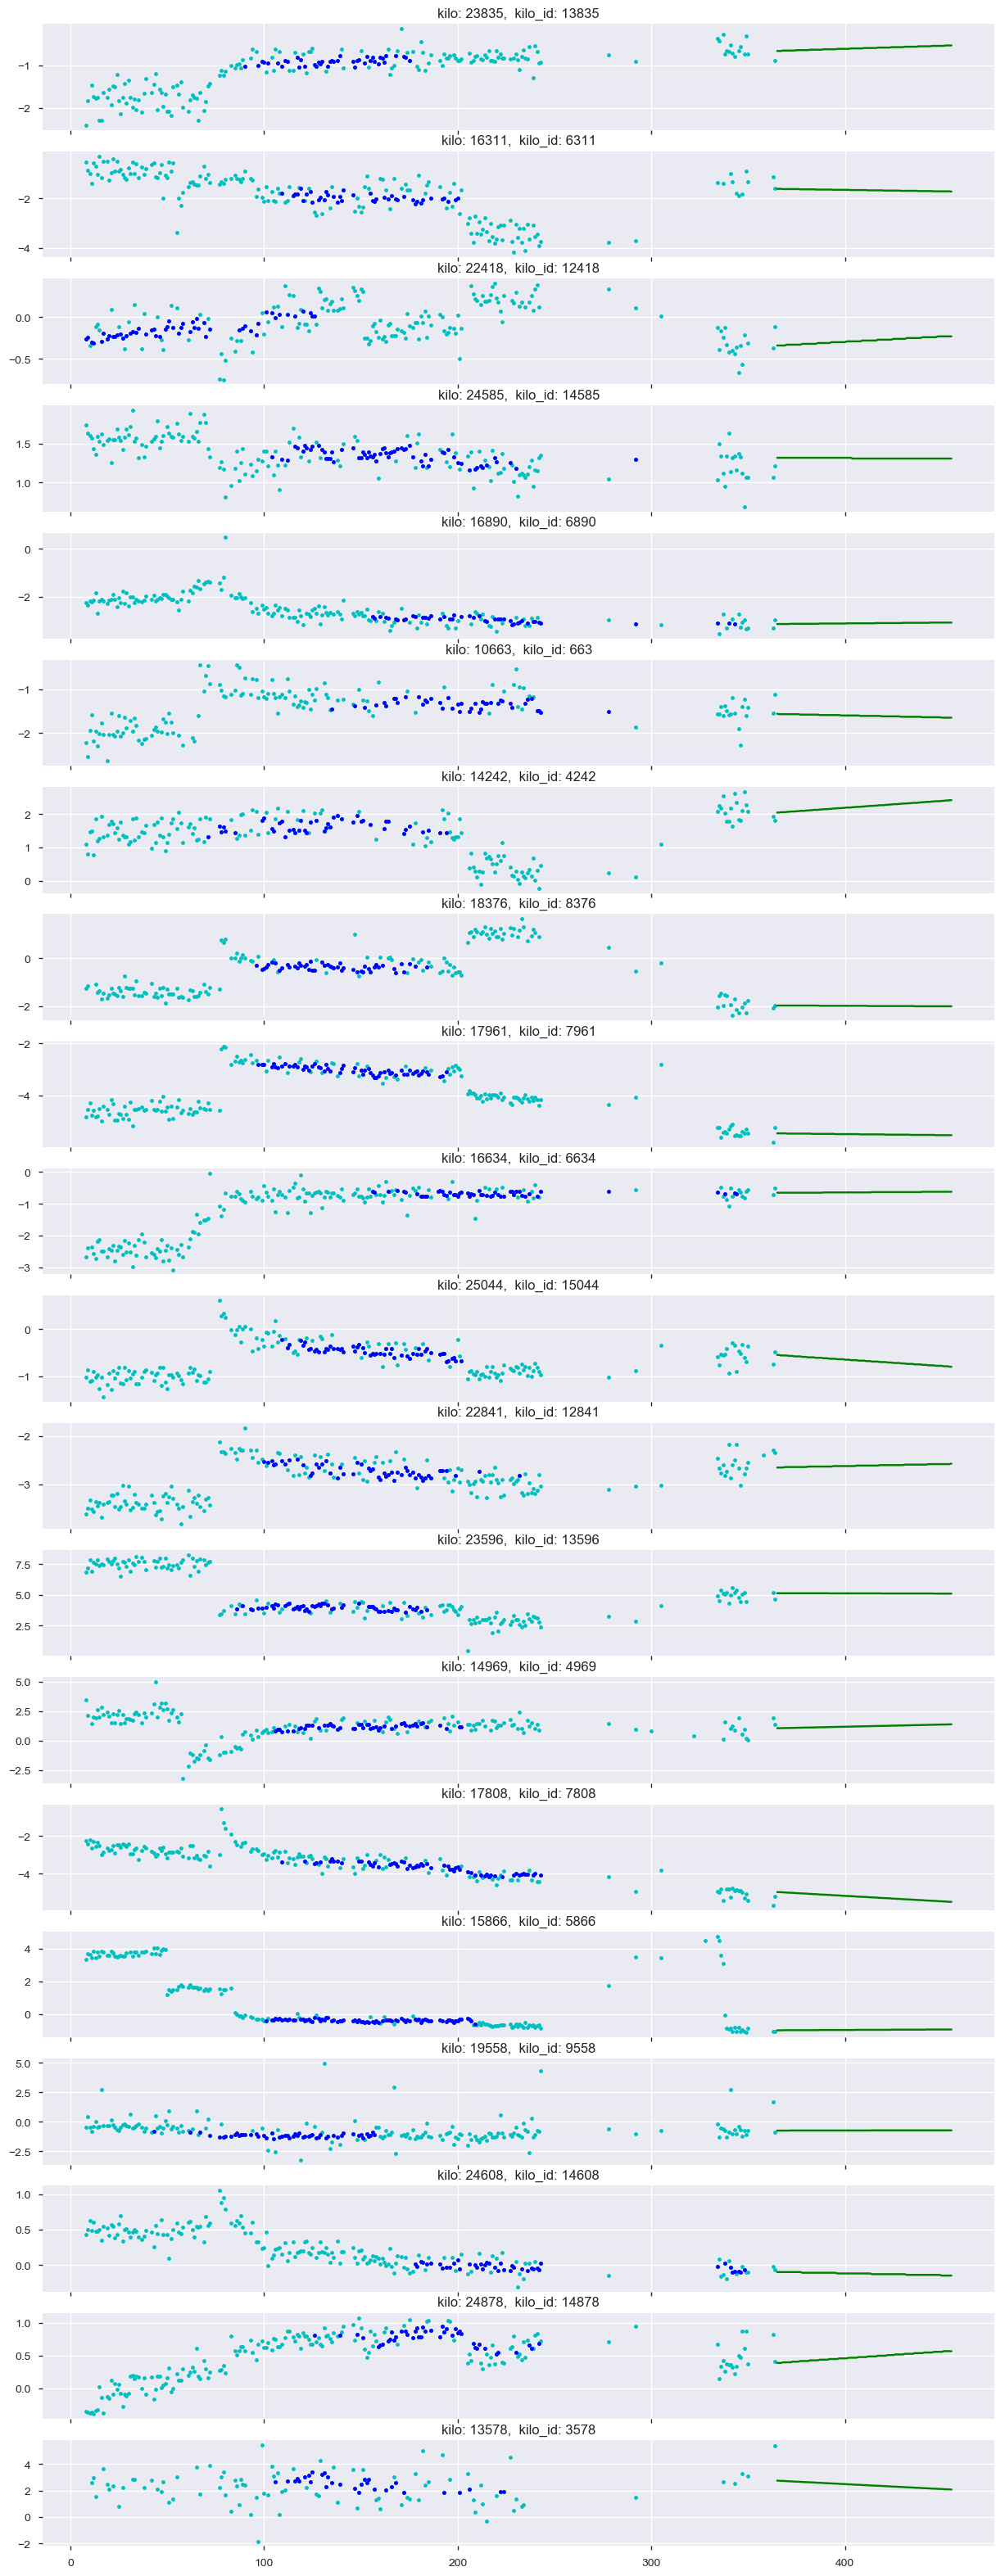

In [88]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['D']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91 + len(tracks['C']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

In [89]:
submision.to_csv("submit12_refine.csv", header=None)